# Data México
## Importar bibliotecas

In [35]:
import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import requests

## Leemos el archivo JSON del mapa de México

In [36]:
url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json'
Mx_mapa_estados = requests.get(url).json()

In [37]:
# Averiguamos la manera en la que están escritos los nombres de los estados
states = []
for i in range(32):
    states.append(Mx_mapa_estados["features"][i]["properties"]["name"])

In [38]:
# Organizamos la lista de estados por orden alfabético
states.sort()
states

['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Ciudad de México',
 'Coahuila',
 'Colima',
 'Durango',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán',
 'Morelos',
 'México',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Querétaro',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz',
 'Yucatán',
 'Zacatecas']

## Leemos los diferentes csv's

### Reporte de mobilidad por estados de México - Google

In [39]:
mob_google = pd.read_csv("Databases/2020_MX_Region_Mobility_Report_Google.csv")

In [40]:
mob_google.head(10)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-15,6,4,6,4.0,3,-1
1,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-16,7,6,7,6.0,2,-1
2,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-17,2,4,3,5.0,11,-2
3,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-18,0,-1,3,2.0,9,-2
4,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-19,0,0,2,3.0,8,-1
5,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-20,0,-1,2,3.0,7,-1
6,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-21,-2,-2,-1,4.0,11,-1
7,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-22,0,0,7,4.0,4,0
8,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-23,2,1,8,7.0,2,-1
9,MX,Mexico,NaN,NaN,NaN,NaN,NaN,2020-02-24,-2,0,6,4.0,8,-1


In [41]:
# Checamos la manera en la que están escritos los estados y corroboramos con nuestro mapa. El "nan" hace referencia a el país entero
mob_google["sub_region_1"].unique()

array([nan, 'Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Coahuila', 'Colima',
       'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco',
       'Mexico City', 'Michoacán', 'Morelos', 'Nayarit', 'Nuevo Leon',
       'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo', 'San Luis Potosi',
       'Sinaloa', 'Sonora', 'State of Mexico', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz', 'Yucatan', 'Zacatecas'], dtype=object)

In [42]:
# Reemplazamos los más obvios para luego comparar con la lista de estados del mapa
mob_google = mob_google.replace(["Mexico City", "State of Mexico"], ["Ciudad de México", "México"])
st_google = []
for i in range(1,33):
    st_google.append(mob_google["sub_region_1"].unique()[i])
st_google.sort()
for i in range(len(st_google)):
    print(st_google[i],states[i])
    # Mas adelante corroborara si los acentos influyen

In [43]:
# Reemplazamos los nombres de los estados para que sean iguales a los del Mapa
for i in range(len(st_google)):
    mob_google = mob_google.replace(st_google[i], states[i])
mob_google["sub_region_1"].unique()

array([nan, 'Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Coahuila', 'Colima',
       'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco',
       'Ciudad de México', 'Michoacán', 'Morelos', 'Nayarit',
       'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'México', 'Tabasco',
       'Tamaulipas', 'Tlaxcala', 'Veracruz', 'Yucatán', 'Zacatecas'],
      dtype=object)

In [44]:
# Cambiamos los nombres de las columnas a español y eliminamos columnas innecesarias
mob_google = mob_google.rename(columns= {'retail_and_recreation_percent_change_from_baseline': "Comercios y lugares recreativos",
                            'grocery_and_pharmacy_percent_change_from_baseline': "Farmacias y supermercados",
                            'parks_percent_change_from_baseline':"Parques",
                            'transit_stations_percent_change_from_baseline':'Estaciones de tránsito',
                            'workplaces_percent_change_from_baseline': "Lugares de trabajo",
                            'residential_percent_change_from_baseline':"Lugares residenciales"})
mob_google = mob_google.drop(columns=["sub_region_2", "metro_area", "iso_3166_2_code", "census_fips_code","country_region_code"])
mob_google

,country_region,sub_region_1,date,Cambio porcentual en la asistencia a comercios y lugares recreativos,Cambio porcentual en la asistencia a farmacias y supermercados,Cambio porcentual en la estadía de parques,Cambio porcentual en la estadía de estaciones de tránsito,Cambio porcentual en la estadía de lugares de trabajo,Cambio porcentual en la estadía de lugares residenciales
0,Mexico,NaN,2020-02-15,6,4,6,4.0,3,-1
1,Mexico,NaN,2020-02-16,7,6,7,6.0,2,-1
2,Mexico,NaN,2020-02-17,2,4,3,5.0,11,-2
3,Mexico,NaN,2020-02-18,0,-1,3,2.0,9,-2
4,Mexico,NaN,2020-02-19,0,0,2,3.0,8,-1
...,...,...,...,...,...,...,...,...,...
9301,Mexico,Zacatecas,2020-11-18,-32,-8,-46,-34.0,-29,10
9302,Mexico,Zacatecas,2020-11-19,-32,-8,-46,-35.0,-31,11
9303,Mexico,Zacatecas,2020-11-20,-35,-9,-48,-36.0,-26,11
9304,Mexico,Zacatecas,2020-11-21,-35,-8,-42,-35.0,-1,6


### Gráficas de Prueba

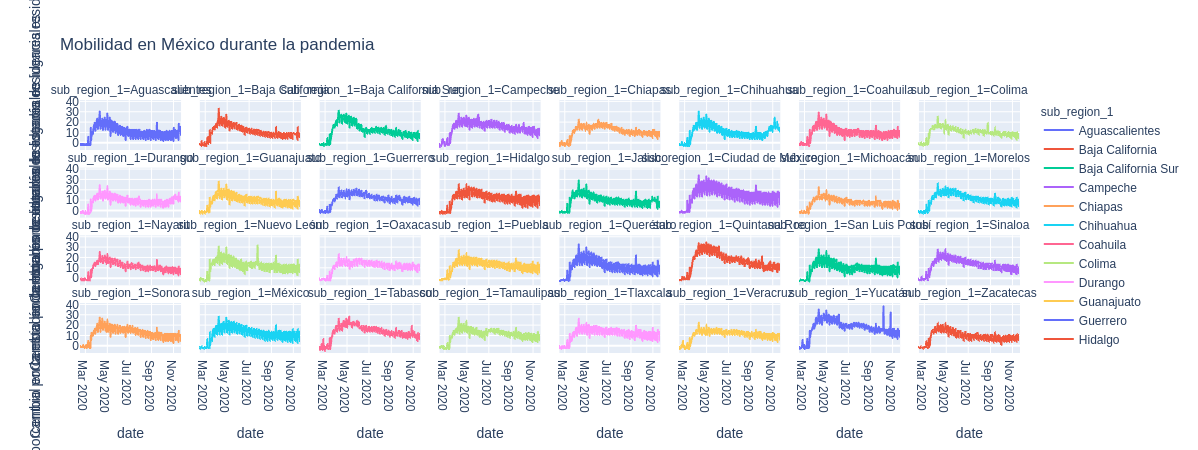

In [23]:
fig = px.line(mob_google[mob_google["sub_region_1"].notnull()], 
              x="date", y="Cambio porcentual en la estadía de lugares residenciales",
              color="sub_region_1", facet_col = "sub_region_1", 
              facet_col_wrap=8, title = "Mobilidad en México durante la pandemia", )
fig.show()

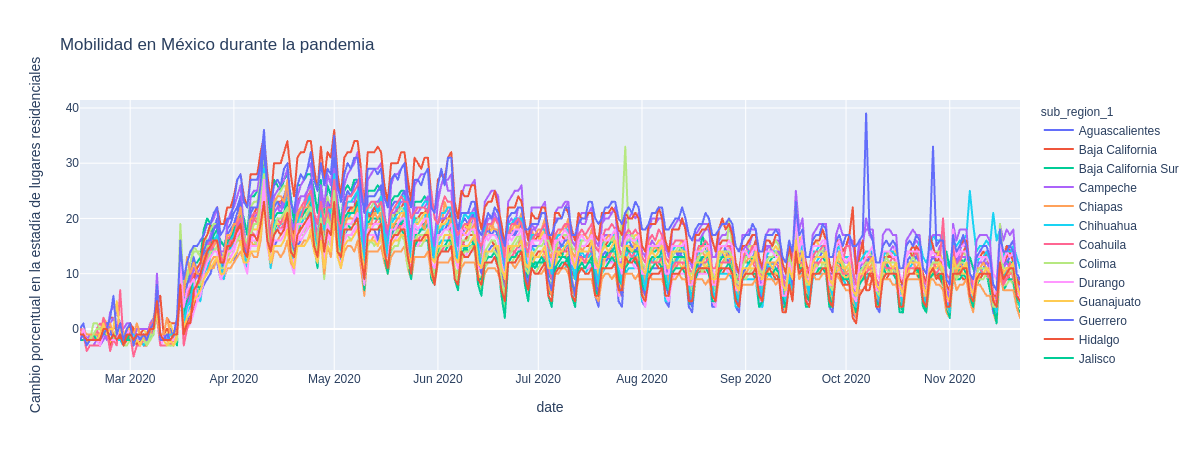

In [12]:
fig = px.line(mob_google[mob_google["sub_region_1"].notnull()], x="date", y="Cambio porcentual en la estadía de lugares residenciales", color="sub_region_1", animation_group="Cambio porcentual en la estadía de lugares residenciales",title = "Mobilidad en México durante la pandemia")
fig.show()

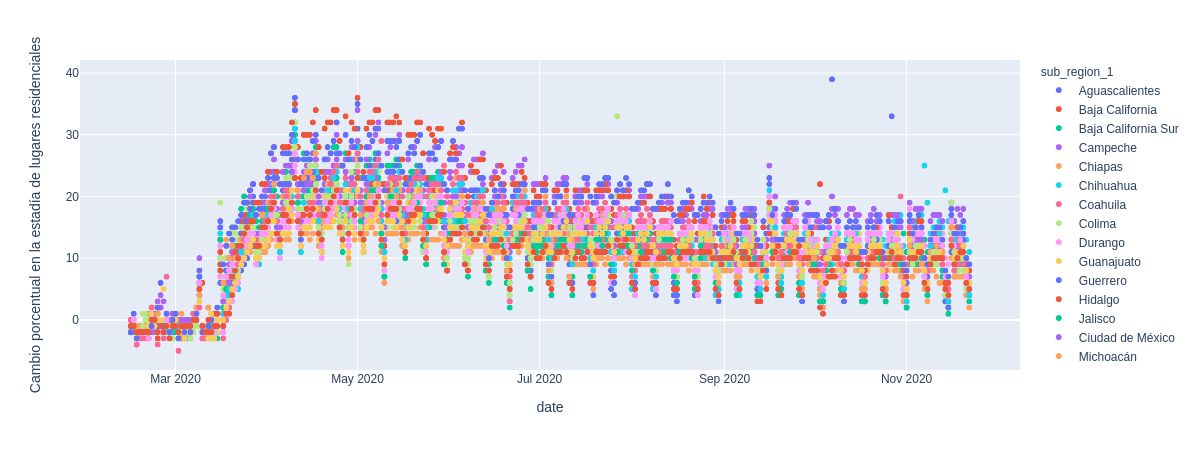

In [24]:
fig = px.scatter(mob_google[mob_google["sub_region_1"].notnull()], x="date",y="Cambio porcentual en la estadía de lugares residenciales",color="sub_region_1")
fig.show()

### Gráficas de movilidad durante la cuarentena para cada estado

Como primer paso hay que definir cuándo empezó la cuarentena en México. Según https://www.gob.mx/cms/uploads/attachment/file/541687/Jornada_Nacional_de_Sana_Distancia.pdf empézó el 23 de Marzo del 2020. Entonces hay que agregar una columna que nos permita discernir entre movilidad pre y durante la cuarentena.

In [45]:
# Creamos una función que nos permita asignar el valor Durante Cuarentena y Antes de la Cuarentena
def cuarentena(fecha):
    # Documentación:
    # Evalúa la fecha de entrada y arroja si ésta ocurrió antes de la cuarentena o después  (23 de Marzo del 2020)
    
    # Argumentos:
    # fecha = e.g. 2020-03-23
    
    f_cuarentena = "2020-03-23"
    # Utilizamos un ciclo if para definir ambos casos
    if fecha < f_cuarentena:
        return "Antes de la Cuarentena"
    else:
        return "Durante la Cuarentena"
    
# Creamos la función que nos devuelva la gráfica
def movilidad_google(df,estado):
    # Documentación:
    # Toma el datafram de movilidad de google procesado y devuelve una gráfica dependiendo del estado que se eligió
    
    # Argumentos:
    # df = dataframe de movilidad de google procesado
    # estado = Nombre del estado (str)
    
    df["Cuarentena"] = df["date"].apply(cuarentena)
    if estado == "País":
        df_estado = df[df["sub_region_1"].isnull()]
    else:
        df_estado = df[df["sub_region_1"] == estado]
    
    import datetime
    df_estado["date"] = pd.to_datetime(df_estado["date"])
    df_estado.set_index("date",inplace=True)
    
    df_estado_2 = df_estado.resample("W").agg("mean")
    
    durante_la_cuarentena = df_estado["Cuarentena"].where(df_estado["Cuarentena"] == "Durante la Cuarentena").first_valid_index()
    antes_de_la_cuarentena = df_estado["Cuarentena"].where(df_estado["Cuarentena"] == "Antes de la Cuarentena").first_valid_index()
    mindate = df_estado.index.min()
    maxdate = df_estado.index.max()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[durante_la_cuarentena],
                             y=[39],
                             text=["<b>Empieza la Cuarentena</b>"],
                             mode="text"))
    
    l = df_estado_2.columns
    colors = px.colors.qualitative.G10
    
    for i in range(len(l)):
        fig.add_trace(go.Scatter(x=df_estado_2.index,
                                 y=df_estado_2[l[i]],
                                 mode="lines+markers",
                                 name=l[i],
                                 marker_color=colors[i])
                     )
        
        fig.update_layout(xaxis=dict(range=[mindate,maxdate]), template="plotly_white")
        
        fig.update_layout(title="Cambios en la Movilidad de los Habitantes del estado de {} durante la Cuarentena".format(estado),
                          width=1400,
                          height=600,
                          legend_title="Movilidad",
                          shapes=[dict(type="line",
                                       x0=mindate,
                                       y0=0,
                                       x1=maxdate,
                                       y1=0,
                                       line_width=2,
                                       line= dict(dash="dot")),
                                  dict(type="line",
                                       x0=durante_la_cuarentena,
                                       y0=-100,
                                       x1=durante_la_cuarentena,
                                       y1=37,
                                       line_width=2,
                                       line= dict(dash="dot"))
                                 ]
                         )
    return fig.show()

<ipython-input-45-3050c3b8fa08>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



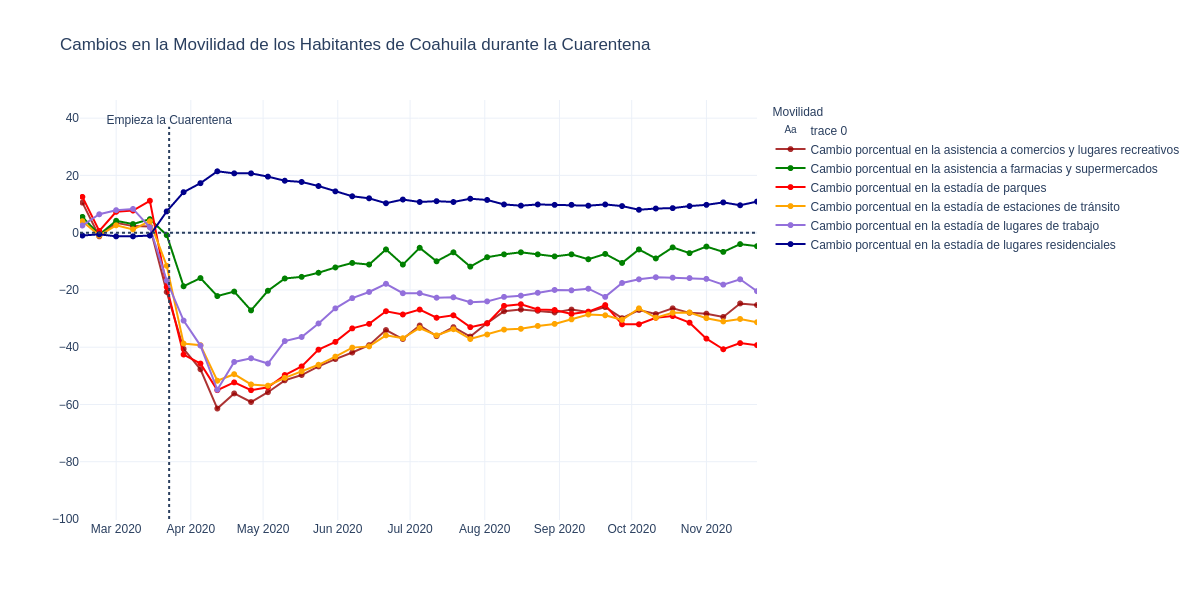

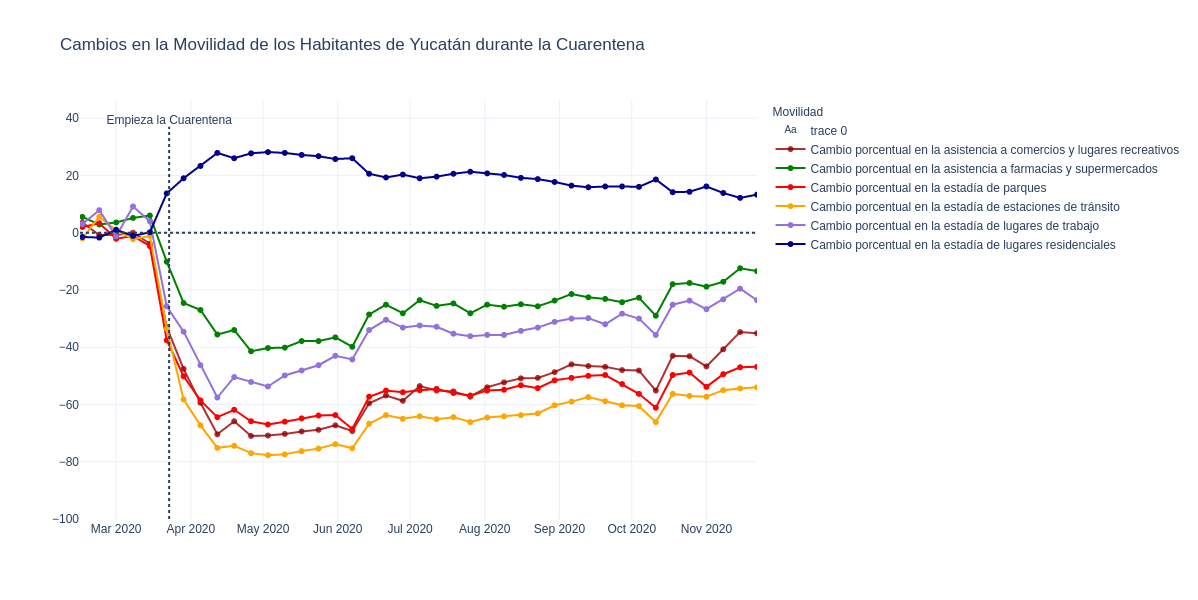

In [46]:
vcm

In [47]:
md

,country_region,sub_region_1,date,Cambio porcentual en la asistencia a comercios y lugares recreativos,Cambio porcentual en la asistencia a farmacias y supermercados,Cambio porcentual en la estadía de parques,Cambio porcentual en la estadía de estaciones de tránsito,Cambio porcentual en la estadía de lugares de trabajo,Cambio porcentual en la estadía de lugares residenciales,Cuarentena
0,Mexico,NaN,2020-02-15,6,4,6,4.0,3,-1,Antes de la Cuarentena
1,Mexico,NaN,2020-02-16,7,6,7,6.0,2,-1,Antes de la Cuarentena
2,Mexico,NaN,2020-02-17,2,4,3,5.0,11,-2,Antes de la Cuarentena
3,Mexico,NaN,2020-02-18,0,-1,3,2.0,9,-2,Antes de la Cuarentena
4,Mexico,NaN,2020-02-19,0,0,2,3.0,8,-1,Antes de la Cuarentena
...,...,...,...,...,...,...,...,...,...,...
9301,Mexico,Zacatecas,2020-11-18,-32,-8,-46,-34.0,-29,10,Durante la Cuarentena
9302,Mexico,Zacatecas,2020-11-19,-32,-8,-46,-35.0,-31,11,Durante la Cuarentena
9303,Mexico,Zacatecas,2020-11-20,-35,-9,-48,-36.0,-26,11,Durante la Cuarentena
9304,Mexico,Zacatecas,2020-11-21,-35,-8,-42,-35.0,-1,6,Durante la Cuarentena


In [48]:
def crime_lines(df, delito, estado):
    fig = go.Figure()
    for year in df["Año"].unique():
        fig.add_trace(go.Scatter(x=df["Mes"], y = df[(df["Tipo de delito"]==delito) & (df["Entidad"]==estado) & (df["Año"]==year)]["Incidencia"],mode="lines+markers",name=str(year)))
    fig.add_shape(type="line",x0="Marzo",x1="Marzo",y0=0,y1=df[(df["Tipo de delito"]==delito) & (df["Entidad"]==estado)]["Incidencia"].max(), layer="below", line=dict(width=5, dash="dot"))
    fig.add_shape(type="line",x0="Abril",x1="Abril",y0=0,y1=df[(df["Tipo de delito"]==delito) & (df["Entidad"]==estado)]["Incidencia"].max(), layer="below", line=dict(width=5, dash="dot"))
    fig.update_layout(title="{} en el estado de {} a través del tiempo".format(delito, estado),template="plotly_white")
    

    return fig.show()


,country_region,sub_region_1,date,Cambio porcentual en la asistencia a comercios y lugares recreativos,Cambio porcentual en la asistencia a farmacias y supermercados,Cambio porcentual en la estadía de parques,Cambio porcentual en la estadía de estaciones de tránsito,Cambio porcentual en la estadía de lugares de trabajo,Cambio porcentual en la estadía de lugares residenciales,Cuarentena
8742,Mexico,Yucatán,2020-02-15,5,7,5,-2.0,5,-2,Antes de la Cuarentena
8743,Mexico,Yucatán,2020-02-16,2,4,-1,-2.0,1,-1,Antes de la Cuarentena
8744,Mexico,Yucatán,2020-02-17,2,6,2,8.0,10,-3,Antes de la Cuarentena
8745,Mexico,Yucatán,2020-02-18,-1,4,5,2.0,10,-2,Antes de la Cuarentena
8746,Mexico,Yucatán,2020-02-19,0,3,7,4.0,10,-2,Antes de la Cuarentena
...,...,...,...,...,...,...,...,...,...,...
9019,Mexico,Yucatán,2020-11-18,-32,-12,-44,-53.0,-28,14,Durante la Cuarentena
9020,Mexico,Yucatán,2020-11-19,-31,-13,-47,-53.0,-29,15,Durante la Cuarentena
9021,Mexico,Yucatán,2020-11-20,-33,-9,-44,-53.0,-25,14,Durante la Cuarentena
9022,Mexico,Yucatán,2020-11-21,-39,-12,-46,-55.0,-5,10,Durante la Cuarentena


In [49]:
for estate in ["Baja California", "Guerrero"]:
    crime_lines(md, "Hostigamiento sexual", estate)

In [50]:
fig = go.Figure()
for year in md["Año"].unique():
    fig.add_trace(go.Scatter(x=md["Mes"], y = md[(md["Tipo de delito"]=="Violencia familiar") & (md["Entidad"]=="Ciudad de México") & (md["Año"]==year)]["Incidencia"],mode="lines+markers",name=str(year)))
fig.add_shape(type="line",x0="Marzo",x1="Marzo",y0=0,y1=md[(md["Tipo de delito"]=="Violencia familiar") & (md["Entidad"]=="Ciudad de México") & (md["Año"]==year)]["Incidencia"].max(), layer="below", line=dict(width=5, dash="dot"))
fig.add_shape(type="line",x0="Abril",x1="Abril",y0=0,y1=md[(md["Tipo de delito"]=="Violencia familiar") & (md["Entidad"]=="Ciudad de México") & (md["Año"]==year)]["Incidencia"].max(), layer="below", line=dict(width=5, dash="dot"))
fig.update_layout(title="{} en {} a través del tiempo".format(delito, estado),template="plotly_white")
#fig.add_trace(go.Scatter(x=["2020-04-8"],y=[160], text="<b>Primer mes en</b>", mode="text", textfont_size=12))
#fig.add_trace(go.Scatter(x=["2020-04-8"],y=[150], text="<b>cuarentena</b>", mode="text", textfont_size=12))
#fig.add_trace(go.Scatter(x=["2020-04-8"],y=[140], text="23 de Marzo al", mode="text", textfont_size=10))
#fig.add_trace(go.Scatter(x=["2020-04-8"],y=[130], text="23 de Abril", mode="text", textfont_size=10))
fig.show()

<ipython-input-50-49103c301491>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
md[(md["Tipo de delito"]=="Violencia familiar") & (md["Entidad"]=="Yucatán") & (md["Año"]==2018)]

## Movilidad de México como país durante la Cuarentena

In [52]:
## Buscamos los valores más altos y bajos en el lapso de marzo 22 a abril 22 de tiempo en sus casas

,Cambio porcentual en la asistencia a comercios y lugares recreativos,Cambio porcentual en la asistencia a farmacias y supermercados,Cambio porcentual en la estadía de parques,Cambio porcentual en la estadía de estaciones de tránsito,Cambio porcentual en la estadía de lugares de trabajo,Cambio porcentual en la estadía de lugares residenciales
date,,,,,,
2020-02-16,3.500000,5.500000,2.000000,-2.000000,3.000000,-1.500000
2020-02-23,-0.857143,2.857143,3.285714,5.571429,7.857143,-1.714286
2020-03-01,-0.857143,3.571429,-2.142857,0.857143,-1.285714,1.000000
2020-03-08,0.000000,5.142857,-1.142857,-2.285714,9.142857,-1.142857
2020-03-15,-3.857143,6.000000,-4.714286,-1.142857,4.000000,0.142857
2020-03-22,-33.000000,-10.142857,-37.571429,-33.571429,-25.714286,13.714286
2020-03-29,-47.571429,-24.571429,-50.142857,-58.285714,-34.571429,19.000000
2020-04-05,-59.428571,-27.000000,-58.571429,-67.285714,-46.285714,23.285714
2020-04-12,-70.428571,-35.571429,-64.428571,-75.142857,-57.571429,27.857143


In [53]:
# Buscar los valores más altos entre el lapso de marzo 22 a abril 22 2020
mob_google_lapso = mob_google.loc[(mob_google["date"] >= "2020-03-22") & (mob_google["date"] <= "2020-04-22")] # Delimitamos la fecha a un mes 
mas_alto = mob_google_lapso["Lugares residenciales"].max() # Encontramos el valor más alto
mas_bajo = mob_google_lapso["Lugares residenciales"].min() # Encontramos el valor más bajo
estados_mas_t_casa = mob_google_lapso.loc[mob_google_lapso["Lugares residenciales"] >= mas_alto-2] # Buscamos los estados que cumplan con esta condición
estados_menos_t_casa = mob_google_lapso.loc[mob_google_lapso["Lugares residenciales"] <= mas_bajo+1] # Buscamos los estados que cumplan con esta condición
estados_menos_t_casa

#### Estados que permanecieron más tiempo en casa durante el primer mes de cuarentena

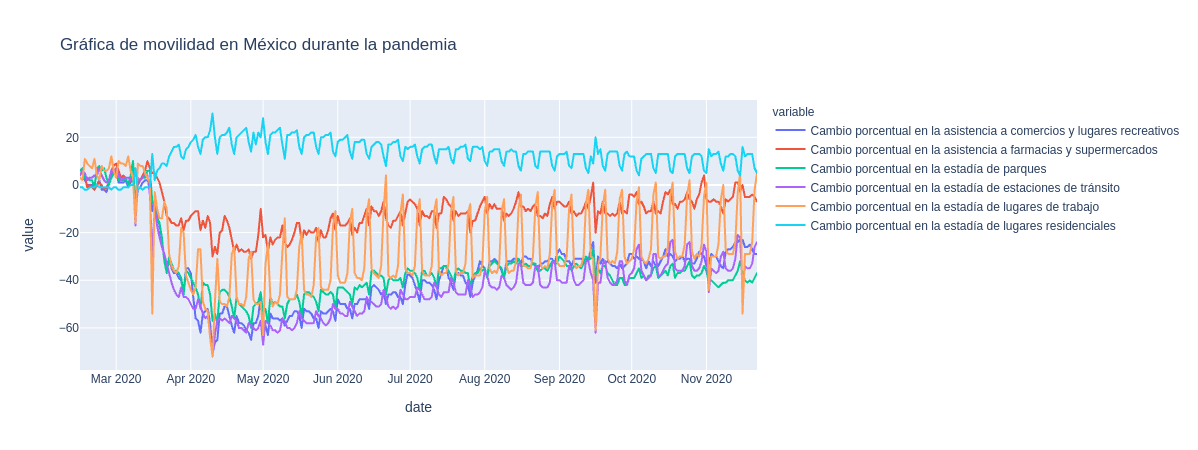

In [54]:
for estado in estados_mas_t_casa["sub_region_1"].unique():
    movilidad_google(mob_google, estado)

#### Estados que permanecieron menos tiempo en casa durante el primer mes de cuarentena

In [ ]:
for estado in estados_menos_t_casa["sub_region_1"].unique():
    movilidad_google(mob_google, estado)

### Reporte de movilidad en México - Apple

In [58]:
mob_apple = pd.read_csv("Databases/applemobilitytrends-2020-11-25.csv")

/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [59]:
mob_apple.head(10)

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,98.04,91.08,90.14,97.88,99.05,111.07,115.80,99.44,97.01,94.64
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,138.00,129.17,121.41,126.01,120.09,123.58,107.08,128.61,119.49,122.56
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,61.42,64.85,70.25,73.21,91.41,99.28,72.55,59.53,60.29,63.91
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,52.37,55.46,57.55,60.21,70.59,68.75,45.72,42.96,49.73,53.32
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,97.26,101.44,101.82,109.64,108.84,91.48,95.10,99.52,103.98,107.94
5,country/region,Australia,transit,AU,NaN,NaN,100.0,101.78,100.64,99.58,...,61.78,62.79,62.17,66.55,69.77,57.04,60.45,64.65,67.14,69.48
6,country/region,Australia,walking,AU,NaN,NaN,100.0,101.31,101.82,104.52,...,77.13,80.66,81.56,88.82,106.37,86.94,76.02,81.94,85.49,88.96
7,country/region,Austria,driving,Österreich,NaN,NaN,100.0,101.14,104.24,112.21,...,83.79,62.18,65.30,64.30,61.09,53.08,58.79,65.65,67.90,67.28
8,country/region,Austria,walking,Österreich,NaN,NaN,100.0,101.55,105.59,112.24,...,69.52,52.56,56.40,51.79,49.55,47.28,48.09,53.23,55.09,54.14
9,country/region,Belgium,driving,België|Belgique,NaN,NaN,100.0,101.19,107.49,107.67,...,78.12,79.44,87.29,81.04,84.86,78.68,71.01,80.45,82.04,83.95


In [60]:
# Filtramos la tabla por los datos de México
mx_mob_apple = mob_apple.loc[mob_apple['region'] == "Mexico"]
mx_mob_apple

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25
82,country/region,Mexico,driving,México,NaN,NaN,100.0,100.53,102.35,106.06,...,87.51,84.85,86.40,90.21,109.71,116.34,86.12,85.82,86.95,89.94
83,country/region,Mexico,transit,México,NaN,NaN,100.0,100.05,100.15,101.98,...,51.13,56.13,55.53,56.64,57.83,53.96,47.66,55.33,56.84,55.98
84,country/region,Mexico,walking,México,NaN,NaN,100.0,102.15,105.42,107.62,...,87.62,92.23,91.70,96.81,112.07,121.36,86.29,96.52,96.57,99.74


In [61]:
# Eliminamos columnas innecesarias y con NA
mx_mob_apple = mx_mob_apple.drop(columns=["alternative_name", "sub-region", "country"])
mx_mob_apple = mx_mob_apple.dropna(axis=1) 
mx_mob_apple

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25
82,country/region,Mexico,driving,100.0,100.53,102.35,106.06,127.97,134.25,93.02,...,87.51,84.85,86.40,90.21,109.71,116.34,86.12,85.82,86.95,89.94
83,country/region,Mexico,transit,100.0,100.05,100.15,101.98,110.88,96.82,77.79,...,51.13,56.13,55.53,56.64,57.83,53.96,47.66,55.33,56.84,55.98
84,country/region,Mexico,walking,100.0,102.15,105.42,107.62,127.85,135.02,87.85,...,87.62,92.23,91.70,96.81,112.07,121.36,86.29,96.52,96.57,99.74


In [62]:
# Traducimos a español el tipo de transporte
mx_mob_apple = mx_mob_apple.replace(["driving","transit","walking"], ["Automóvil Propio", "Transporte Público", "Caminando"])
mx_mob_apple

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25
82,country/region,Mexico,Automóvil Propio,100.0,100.53,102.35,106.06,127.97,134.25,93.02,...,87.51,84.85,86.40,90.21,109.71,116.34,86.12,85.82,86.95,89.94
83,country/region,Mexico,Transporte Público,100.0,100.05,100.15,101.98,110.88,96.82,77.79,...,51.13,56.13,55.53,56.64,57.83,53.96,47.66,55.33,56.84,55.98
84,country/region,Mexico,Caminando,100.0,102.15,105.42,107.62,127.85,135.02,87.85,...,87.62,92.23,91.70,96.81,112.07,121.36,86.29,96.52,96.57,99.74


In [63]:
mx_mob_apple = mx_mob_apple.set_index(['geo_type', 'region', 'transportation_type']).stack().reset_index()
mx_mob_apple

TypeError: hasattr(): attribute name must be string

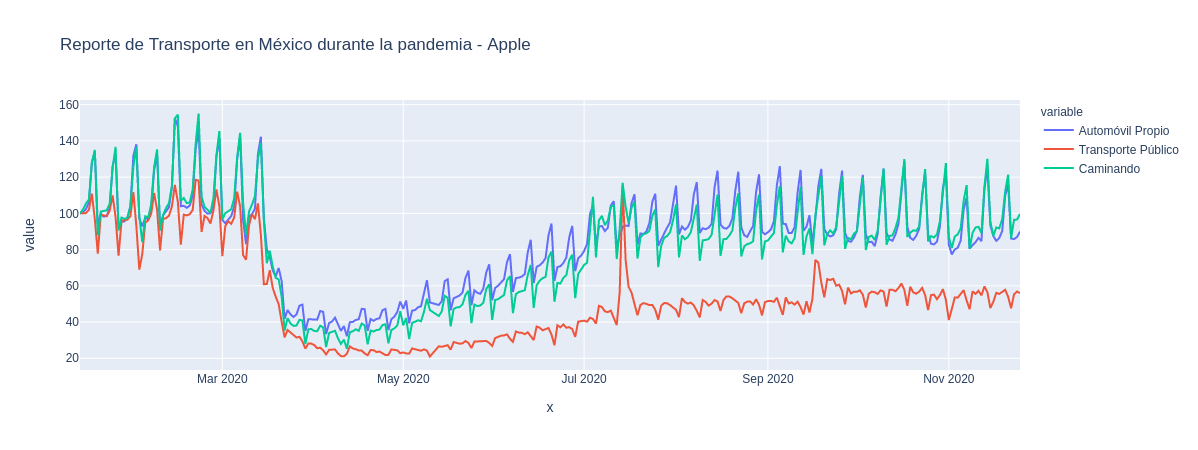

In [64]:
mx_mob_apple.columns = ["Geo_type", "Region", "Tipo de transporte", "Fecha", "Datos"]
mx_mob_apple

In [ ]:
mx_mob_apple[mx_mob_apple.isnull()]

In [ ]:
mx_mob_apple.fillna(0)

In [ ]:
fig = px.line(mx_mob_apple, x="Fecha", y= "Datos", color="Tipo de transporte", title="Reporte de movilidad en México")

fig.add_shape(type="line",x0="2020-03-23",x1="2020-03-23",y0=0,y1=170, layer="below", line=dict(width=1, dash="dot"))
fig.add_shape(type="line",x0="2020-04-23",x1="2020-04-23",y0=0,y1=170, layer="below", line=dict(width=1, dash="dot"))
fig.add_trace(go.Scatter(x=["2020-04-8"],y=[160], text="<b>Primer mes en</b>", mode="text", textfont_size=12))
fig.add_trace(go.Scatter(x=["2020-04-8"],y=[150], text="<b>cuarentena</b>", mode="text", textfont_size=12))
fig.add_trace(go.Scatter(x=["2020-04-8"],y=[140], text="23 de Marzo al", mode="text", textfont_size=10))
fig.add_trace(go.Scatter(x=["2020-04-8"],y=[130], text="23 de Abril", mode="text", textfont_size=10))

fig.show()

### Reporte de Delitos por Municipio del 2015 al 2020 - México

In [65]:
md = pd.read_csv("Databases/Municipal-Delitos-2015-2020_oct2020.csv", encoding="latin_1")

In [66]:
md.head(10)

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1,1,0,1,1,0,2,1,0.0,1.0
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0,0,0,1,0,1,0,0,0.0,0.0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1,1,3,2,0,1,2,0,0.0,0.0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,0,1,0,0,0,0,0,0,0.0,0.0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,...,0,0,1,0,0,0,0,0,0.0,0.0
5,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma blanca,0,...,0,0,0,0,0,0,0,0,0.0,0.0
6,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,En accidente de tránsito,9,...,3,11,6,4,6,6,11,6,3.0,7.0
7,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con otro elemento,0,...,0,0,0,1,0,0,0,0,0.0,0.0
8,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,No especificado,1,...,0,3,0,0,0,0,0,0,0.0,0.0
9,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Lesiones,Lesiones dolosas,Con arma de fuego,1,...,4,1,1,1,3,2,1,3,2.0,2.0


In [ ]:
# Eliminamos columnas innecesarias
md = md.drop(columns=["Cve. Municipio", "Municipio", "Bien jurídico afectado", "Subtipo de delito", "Modalidad"])
md

In [ ]:
# Buscamos is hay NA
md.isnull().values.any()

In [ ]:
# Reemplazamos con NA con 0
md = md.fillna(0)

In [ ]:
# Verificamos si siguen habiendo NA
md.isnull().values.any()

In [ ]:
md

In [ ]:
# Convertimos valores flot a int para que se parezcan a los demás
md["Noviembre"] = md["Noviembre"].astype(int)
md["Diciembre"] = md["Diciembre"].astype(int)
md


In [ ]:
# Sumamos los tipos de delitos iguales (hay muchos debido a que eliminamos los subdelitos)
month_sum_dict = {"Enero":"sum","Febrero":"sum","Marzo":"sum","Abril":"sum","Mayo":"sum","Junio":"sum","Julio":"sum","Agosto":"sum","Septiembre":"sum","Octubre":"sum","Noviembre":"sum","Diciembre":"sum"}
md = md.groupby(["Año","Clave_Ent","Entidad","Tipo de delito"], as_index=False).agg(month_sum_dict)
md

In [ ]:
md = md.set_index(['Año', 'Clave_Ent', 'Entidad', "Tipo de delito"]).stack().reset_index()
md

In [ ]:
# Verificamos los estados en md sean iguales a los del mapa
md_st = []
for state in md["Entidad"].unique():
    md_st.append(state)
md_st.sort()
for i in range(len(states)):
    print(md_st[i],states[i])

In [ ]:
# Reemplazamos los nombres de los estados para que sean iguales a los del Mapa
for i in range(len(states)):
    md = md.replace(md_st[i], states[i])
md["Entidad"].unique()

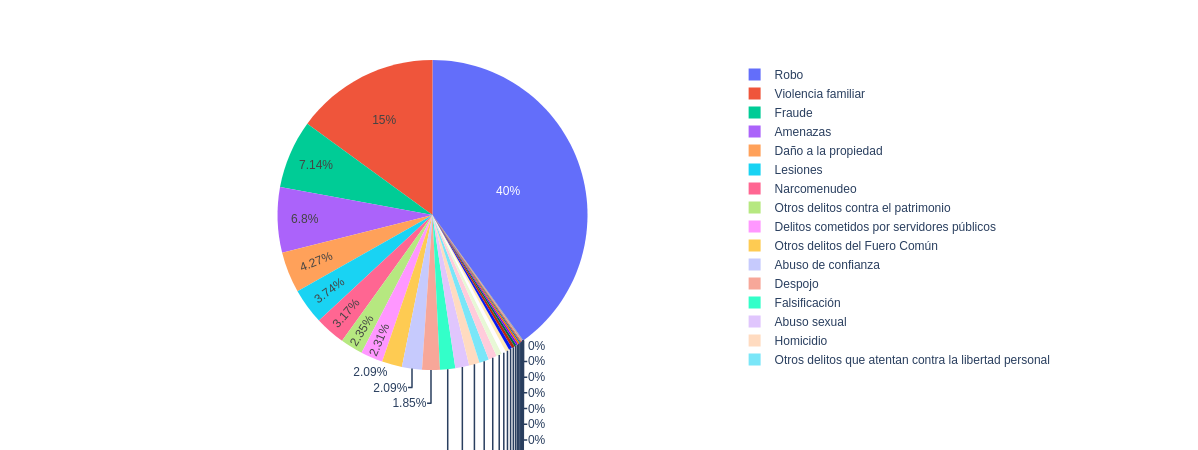

In [ ]:
md

In [ ]:
md.columns = ["Año","Clave_Ent","Entidad","Tipo de delito","Mes","Incidencia"]

In [ ]:
md

In [ ]:
md[(md["Tipo de delito"]=="Homicidio") & (md["Año"]==2016) & (md["Mes"]=="Junio")]

In [ ]:
def pie_delitos(df, entidad, año, mes, crimenes):
    fig = px.pie(df[df["Tipo de delito"].isin(crimenes) & (df["Año"]==año) & (df["Entidad"]==entidad) & df["Mes"].isin(mes)],
                 values="Incidencia", names="Tipo de delito", hover_name="Mes", title="Crímenes en {} en los meses de {} y {} del año {}".format(entidad,mes[0],mes[1],año))
    return fig.show()

In [ ]:
for estado in estados_mas_t_casa["sub_region_1"].unique():
    pie_delitos(md, estado, 2020, ["Marzo","Abril"], ["Violencia familiar", "Abuso sexual", "Feminicidio", "Homicidio","Violación simple",
                                               "Acoso sexual", "Violación equiparada", "Aborto", "Hostigamiento sexual", "Incesto",
                                               "Violencia de género en todas sus modalidades distinta a la violencia familiar",
                                               "Otros delitos contra la familia", "Corrupción de menores",
                                               "Otros delitos que atentan contra la libertad y la seguridad sexual"])

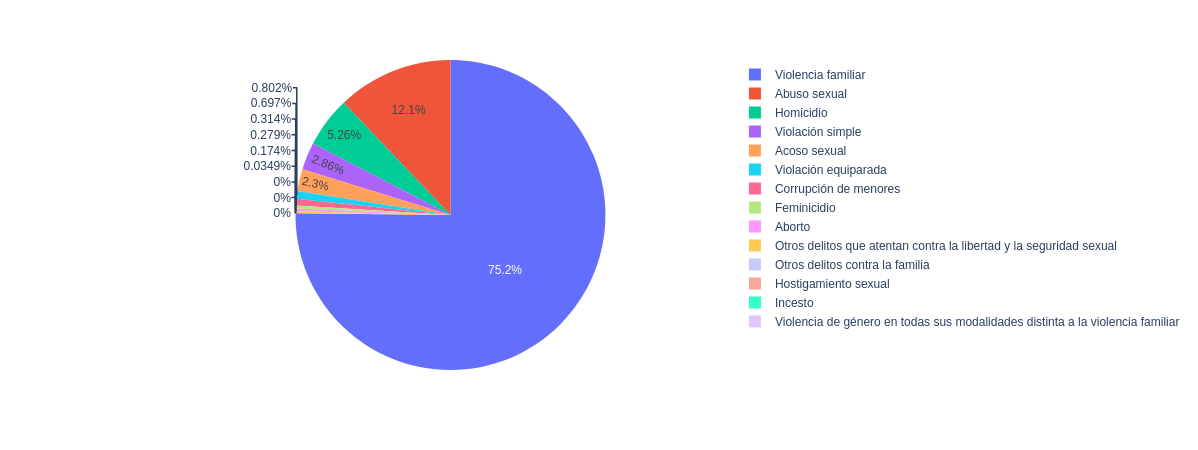

In [ ]:
delitos_im = ["Violencia familiar", "Abuso sexual", "Feminicidio", "Homicidio","Violación simple",
                                               "Acoso sexual", "Violación equiparada", "Aborto", "Hostigamiento sexual", "Incesto",
                                               "Violencia de género en todas sus modalidades distinta a la violencia familiar",
                                               "Otros delitos contra la familia", "Corrupción de menores",
                                               "Otros delitos que atentan contra la libertad y la seguridad sexual"]

In [ ]:
def mapa_delitos(df, delito, mes):
    fig = px.choropleth(data_frame=df[(df["Tipo de delito"]==delito) & (md["Mes"]==mes)], 
                    geojson=Mx_mapa_estados, 
                    locations='Entidad',
                    featureidkey='properties.name',  # ruta al campo del archivo GeoJSON con el que se hará la relación (nombre de los estados)
                    color='Incidencia',
                    animation_frame="Año",
                    color_continuous_scale="burg",
                    height=800,
                    width=1200,
                    title="{} en {} a través de los años".format(delito, mes),
                    range_color=(0,df[(df["Tipo de delito"]==delito) & (md["Mes"]==mes)]["Incidencia"].max())
                    #scope="north america"
                   )
    fig.update_geos(showcountries=True, showcoastlines=False, showland=True, fitbounds="locations")

    return fig.show()

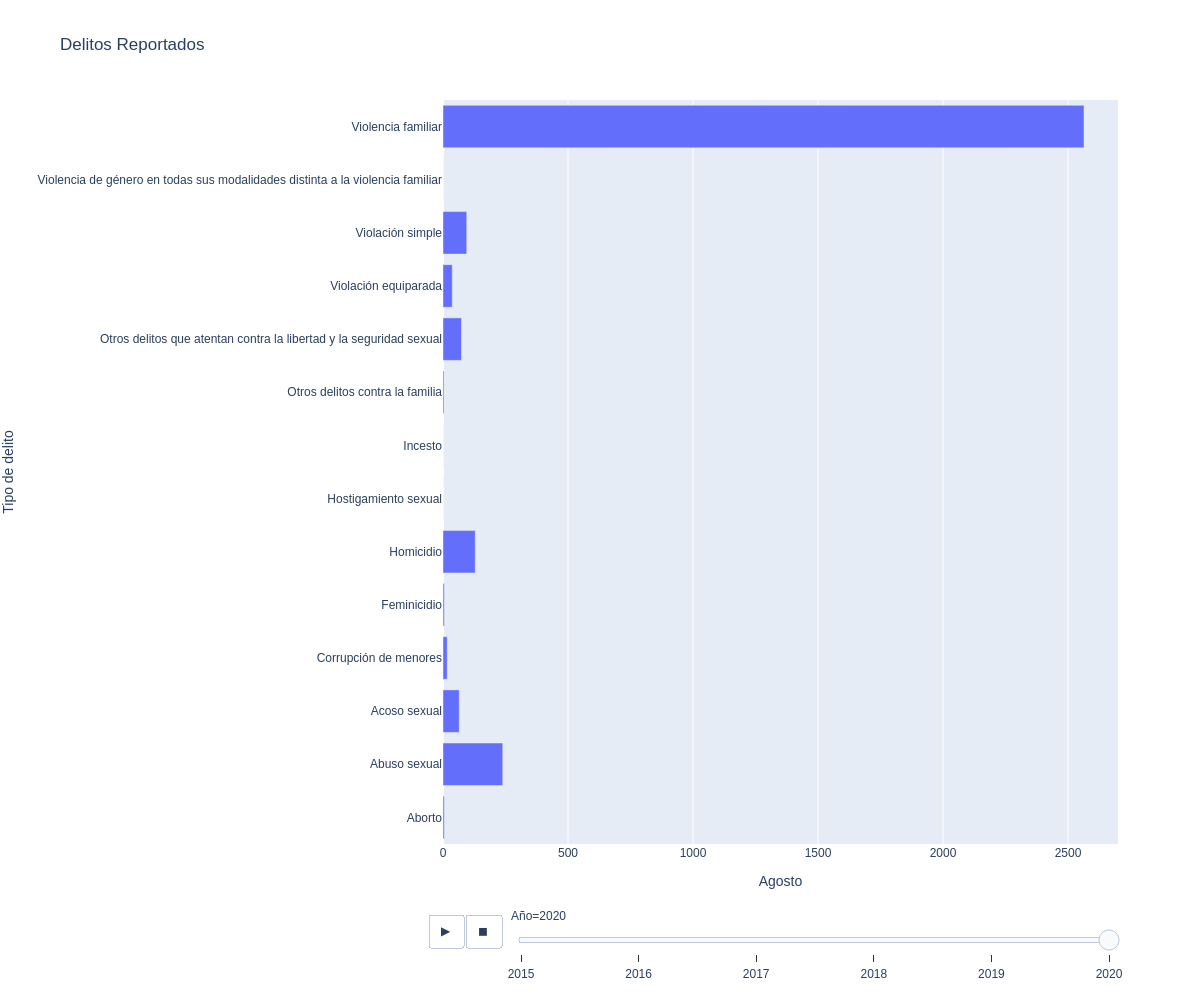

In [ ]:
# Filtrado de delitos
md_delitos = md.loc[md["Tipo de delito"].isin(["Violencia familiar", "Abuso sexual", "Feminicidio", "Homicidio","Violación simple",
                                               "Acoso sexual", "Violación equiparada", "Aborto", "Hostigamiento sexual", "Incesto",
                                               "Violencia de género en todas sus modalidades distinta a la violencia familiar",
                                               "Otros delitos contra la familia", "Corrupción de menores",
                                               "Otros delitos que atentan contra la libertad y la seguridad sexual"])]
md_delitos

In [ ]:
fig = px.pie(md_delitos[(md_delitos["Año"]==2019) & (md_delitos["Entidad"]=="Ciudad de México") & (md_delitos["level_4"]=="Enero")], values=0, names="Tipo de delito", hover_name="Año")
fig.show()

In [ ]:
# Renombramos las columnas
md_delitos.columns = ["Año", "Clave_Ent", "Entidad", "Tipo de delito", "Mes", "Incidencias"]
md_delitos[(md_delitos["Año"]==2015) & (md_delitos["Entidad"]=="Yucatán")]

In [ ]:
def line_delitos(df, entidad, delito):
    fig = px.line(df[(df["Tipo de delito"]==delito) & (df["Entidad"]==entidad)], x="Mes", y="Incidencia", animation_frame="Año",
                  title="{} a través de los años en el estado de {}".format(delito,entidad), range_y=[0,df[(df["Tipo de delito"]==delito) & (df["Entidad"]==entidad)]["Incidencia"].max()])
    return fig.show()

In [ ]:
def bar_delitos_1(df, entidad, delito):
    fig = px.bar(df[(df["Tipo de delito"]==delito) & (df["Entidad"]==entidad)], x="Año", y="Incidencia", color="Año", facet_col="Mes",facet_col_wrap=6, height=800, title="{} en el estado de {} a través del tiempo ".format(delito, entidad))
    return fig.show()

In [ ]:
bar_delitos_1(md, "Ciudad de México","Violencia familiar")

## Análisis de delitos a través del tiempo en los estados que permanecieron mas tiempo en casa

In [ ]:
for estado in estados_mas_t_casa["sub_region_1"].unique():
    for delito in md_delitos["Tipo de delito"].unique():
        bar_delitos_1(md, estado, delito)

## Análisis de delitos a través del tiempo en los estados que permanecieron menos tiempo en casa

In [ ]:
for estado in estados_menos_t_casa["sub_region_1"].unique():
    for delito in md_delitos["Tipo de delito"].unique():
        bar_delitos_1(md, estado, delito)

In [ ]:
# Definimos una función para hacer animaciones
def delitos_estado(df,estado, mes):
    # Documentación
    # Toma un datafram, estado y año como input y devuelve una animación de los delitos que ocurrieron en el estado durante ese año
    
    # Argumentos
    # df = dataframe preprocesado md_delitos
    # estado = estado de méxico (str)
    # año = un año (2015-2020) (int)
    fig = px.bar(df[df["Mes"].isin(mes) & (df["Entidad"]==estado)], x="Incidencias", y="Tipo de delito",
                 animation_frame="Año", title="Delitos en el estado de {} entre {} y {}  a través de los años".format(estado, mes[0],mes[1]),
                 range_x=[0,df[(df["Mes"]==mes[0]) & (df["Entidad"]==estado)]["Incidencias"].max()+df[(df["Mes"]==mes[1]) & (df["Entidad"]==estado)]["Incidencias"].max()], color="Mes",
                 height=1000)
                                                
    return fig.show()

In [ ]:
delitos_estado(md_delitos, "México", ["Marzo","Abril"])

In [ ]:
vcm = pd.read_csv("Databases/Info_delict_violencia_contra_la_mujer-2015_oct_2020.csv", encoding="latin_1")
vcm

In [ ]:
vcm = vcm.fillna(0)
vcm

In [ ]:
vcm = vcm.set_index(['Año', 'Mes', 'Feminicidios']).stack().reset_index()
vcm

In [ ]:
vcm.columns = ["Año", "Mes", "Feminicidios", "Tipo de delito", "Incidencias"]
vcm

In [ ]:
def bar_delitos(delito):
    fig = px.bar(vcm[vcm["Tipo de delito"]==delito], x="Año", y="Incidencias", color="Año", facet_col="Mes",facet_col_wrap=6, height=800, title="{} en México a través del tiempo ".format(delito))
    return fig.show()

In [ ]:
def crime_lines_2(df, delito):
    fig = go.Figure()
    for year in df["Año"].unique():
        fig.add_trace(go.Scatter(x=df["Mes"].unique(), y = df[(df["Tipo de delito"]==delito) & (df["Año"]==year)]["Incidencias"],mode="lines+markers",name=str(year)))
    fig.add_shape(type="line",x0="Marzo",x1="Marzo",y0=0,y1=df[(df["Tipo de delito"]==delito)]["Incidencias"].max(), layer="below", line=dict(width=5, dash="dot"))
    fig.add_shape(type="line",x0="Abril",x1="Abril",y0=0,y1=df[(df["Tipo de delito"]==delito)]["Incidencias"].max(), layer="below", line=dict(width=5, dash="dot"))
    fig.update_layout(title="{} en México a través del tiempo".format(delito),template="plotly_white")
    

    return fig.show()

In [ ]:
vcm["Mes"]

In [ ]:
fig = go.Figure()
for year in vcm["Año"].unique():
    fig.add_trace(go.Scatter(x=vcm["Mes"].unique(), y = vcm[(vcm["Tipo de delito"]=="Homicidio doloso") & (vcm["Año"]==year)]["Incidencias"]))
fig.show()

In [ ]:
for crime in vcm["Tipo de delito"].unique():
    crime_lines_2(vcm,crime)

In [ ]:
fig = go.Figure(data=[go.Bar(name=vcm[vcm["Tipo de delito"]=="Homicidio doloso"]["Año"], x=vcm[])])

In [ ]:
def violencia_mujer(df, mes):
    # Documentación
    # Toma un datafram, estado y año como input y devuelve una animación de los delitos que ocurrieron en el estado durante ese año
    
    # Argumentos
    # df = dataframe preprocesado md_delitos
    # estado = estado de méxico (str)
    # año = un año (2015-2020) (int)
    fig = px.bar(df[(df["Mes"]==mes)], x="Incidencias", y="Tipo de delito", animation_frame="Año",
                 title="Información sobre violencia contra las mujeres en México en el mes de {} a través de los años".format(mes),
                 range_x=[0,df[df["Mes"]==mes]["Incidencias"].max()])
                                                
    return fig.show()

In [ ]:
violencia_mujer(vcm, "Marzo")

In [ ]:
violencia_mujer(vcm, "Abril")

In [ ]:
def line_violencia(df, delito):
    fig = px.line(df[df["Tipo de delito"]==delito], x="Mes", y="Incidencias", color="Tipo de delito", animation_frame="Año",
                  title="{} en México a través de los años".format(delito),
                  range_y=[0,df[df["Tipo de delito"]==delito]["Incidencias"].max()])
    return fig.show()

In [ ]:
for delito in vcm["Tipo de delito"].unique():
    line_violencia(vcm, delito)